In [1]:
import meds
import fitsio
import proplot as pplt
import subprocess
import glob
import os
import numpy as np

In [7]:
def _download_tile(tilename, cwd):
    os.system("mkdir -p data")

    d = fitsio.read(
        os.path.join(cwd, "fnames.fits"),
        lower=True,
    )
    tnames = np.array([
        d["filename"][i].split("_")[0]
        for i in range(d.shape[0])
    ])
    msk = tnames == tilename
    if np.sum(msk) != 4:
        return np.sum(msk)

    d = d[msk]
    mfiles = []
    for band in ["g", "r", "i", "z"]:
        msk = d["band"] == band
        if np.any(msk):
            _d = d[msk]
            for i in range(len(_d)):
                fname = os.path.join(d["path"][msk][i], d["filename"][msk][i])
                cmd = """\
        rsync \
                -av \
                --password-file $DES_RSYNC_PASSFILE \
                ${DESREMOTE_RSYNC_USER}@${DESREMOTE_RSYNC}/%s \
                ./data/%s
        """ % (fname, os.path.basename(fname))
                subprocess.run(cmd, shell=True, check=True)
            mfiles.append("./data/%s" % os.path.basename(fname))

    return mfiles


In [10]:
fnames = sorted(glob.glob("../2022_01_22_run_mdet_final_v1/data_final_nogcut/*.fits"))

In [18]:
find = 10
tilename = os.path.basename(fnames[find]).split("_")[0]
mfiles = _download_tile(tilename, ".")


    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  238.00 bytes/sec
total size is 906526080  speedup is 7617866.22

    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  238.00 bytes/sec
total size is 885818880  speedup is 7443856.13

    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  79.33 bytes/sec
total size is 890853120  speedup is 7486160.67

    DES rsync daemon

receiving incremental file list

sent 19 bytes  received 100 bytes  238.00 bytes/sec
total size is 897989760  speedup is 7546132.44


In [19]:
from pizza_cutter_metadetect.run_metadetect import _preprocess_for_metadetect, _load_gaia_stars
from ngmix.medsreaders import MultiBandNGMixMEDS, NGMixMEDS

In [20]:
meds_list = []
for f in mfiles:
    m = NGMixMEDS(f)
    meds_list.append(m)
mbmeds = MultiBandNGMixMEDS(meds_list)

In [21]:
import yaml

with open("metadetect-v5.yaml", "r") as fp:
    config = yaml.safe_load(fp.read())

In [22]:
gaia_stars = _load_gaia_stars(mbmeds, config["pizza-cutter-preprocessing"])

loaded GAIA star masks


In [23]:
from ngmix.metacal import get_all_metacal

def _get_img_entry(slice_id, rng):
    mbobs = mbmeds.get_mbobs(slice_id)
    mbobs = _preprocess_for_metadetect(config["pizza-cutter-preprocessing"], mbobs, gaia_stars, slice_id, rng) 
    
    mcal_res = get_all_metacal(
        mbobs, psf="fitgauss", types=["noshear"], 
        use_noise_image=True, rng=rng,
    )    
    return mcal_res["noshear"]

In [24]:
d = fitsio.read(fnames[find])

In [27]:
# compute mags - some will be nan
mag_g = 30.0 - 2.5*np.log10(d["mdet_g_flux"])
mag_r = 30.0 - 2.5*np.log10(d["mdet_r_flux"])
mag_i = 30.0 - 2.5*np.log10(d["mdet_i_flux"])
mag_z = 30.0 - 2.5*np.log10(d["mdet_z_flux"])
gmr = mag_g - mag_r
rmi = mag_r - mag_i
imz = mag_i - mag_z

msk = (
    (d["flags"] == 0) 
    & (d["mask_flags"] == 0)
    & (d["mdet_flux_flags"] == 0)
    & (d["mdet_T_ratio"] > 0.5)
    & (d["mdet_s2n"] > 10)
    & (d["mfrac"] < 0.05)
    & (d["mdet_T"] >= 1.9 - 2.8*d["mdet_T_err"])
    & (np.abs(gmr) < 5)
    & (np.abs(rmi) < 5)
    & (np.abs(imz) < 5)
    & np.isfinite(mag_g)
    & np.isfinite(mag_r)
    & np.isfinite(mag_i)
    & np.isfinite(mag_z)
    & (mag_g < 26.5)
    & (mag_r < 26.5)
    & (mag_i < 26.2)
    & (mag_z < 25.6)
    & (d["mdet_step"] == "noshear")
)

dsel = d[msk]
print(np.sum(msk))

msk_ok = (
    (d["flags"] == 0) 
    & (d["mask_flags"] == 0)
    & (d["mdet_flux_flags"] == 0)
    & (d["mdet_T_ratio"] > 0.5)
    & (d["mdet_s2n"] > 10)
    & (d["mfrac"] < 0.05)
    & (d["mdet_T"] < 1.9 - 2.8*d["mdet_T_err"])
    & (np.abs(gmr) < 5)
    & (np.abs(rmi) < 5)
    & (np.abs(imz) < 5)
    & np.isfinite(mag_g)
    & np.isfinite(mag_r)
    & np.isfinite(mag_i)
    & np.isfinite(mag_z)
    & (mag_g < 26.5)
    & (mag_r < 26.5)
    & (mag_i < 26.2)
    & (mag_z < 25.6)
    & (d["mdet_step"] == "noshear")
)


/gpfs02/astro/workarea/beckermr/tmp/ipykernel_10022/2746908025.py:2: RuntimeWarning: invalid value encountered in log10
  mag_g = 30.0 - 2.5*np.log10(d["mdet_g_flux"])
/gpfs02/astro/workarea/beckermr/tmp/ipykernel_10022/2746908025.py:3: RuntimeWarning: invalid value encountered in log10
  mag_r = 30.0 - 2.5*np.log10(d["mdet_r_flux"])
/gpfs02/astro/workarea/beckermr/tmp/ipykernel_10022/2746908025.py:4: RuntimeWarning: invalid value encountered in log10
  mag_i = 30.0 - 2.5*np.log10(d["mdet_i_flux"])
/gpfs02/astro/workarea/beckermr/tmp/ipykernel_10022/2746908025.py:5: RuntimeWarning: invalid value encountered in log10
  mag_z = 30.0 - 2.5*np.log10(d["mdet_z_flux"])


206


[21.49407755353235]
[18.878593762753056]
[18.878593762753056]
[18.878593762753056]
[21.188093800142944]
[21.87922417435142]
[18.91827425114164]
[18.919661769169068]
[18.614958365811887]


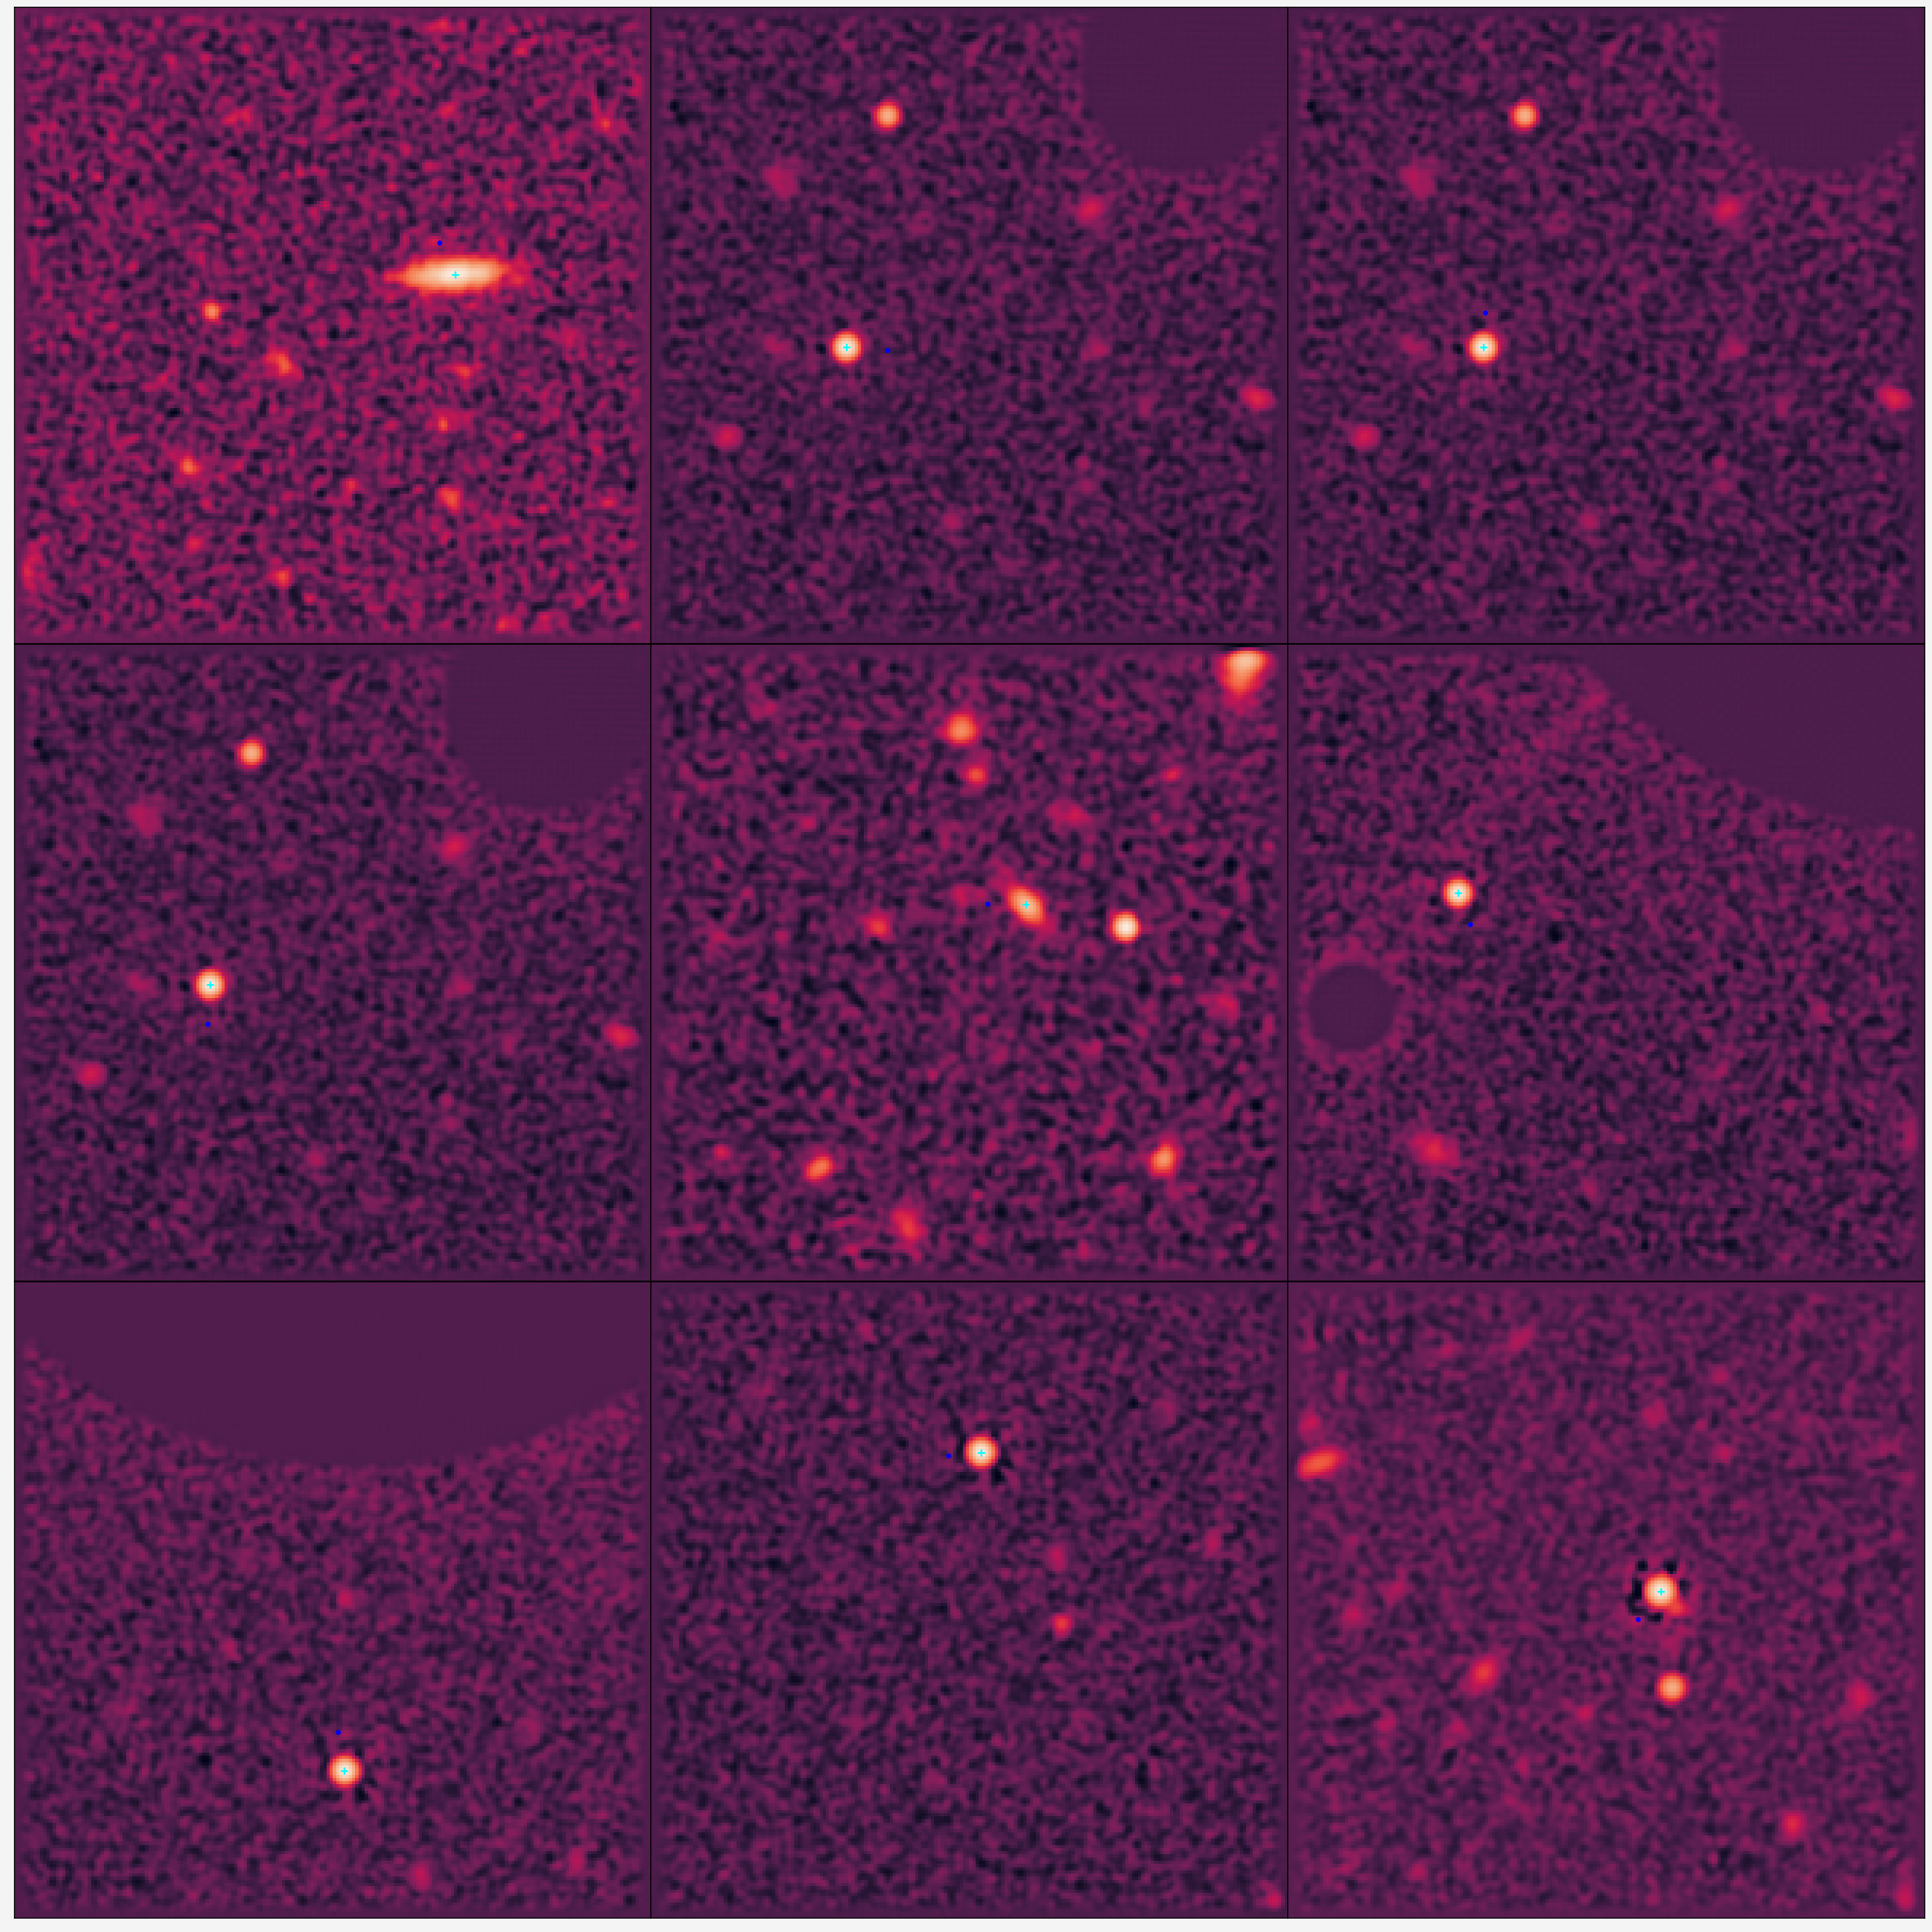

In [42]:
dim = 3
fig, axs = pplt.subplots(nrows=dim, ncols=dim, figsize=(16, 16), hspace=0, wspace=0, share=0)

i = 9
for _i in range(dim):
    for _j in range(dim):
        sid = dsel["slice_id"][i]
        mbobs = _get_img_entry(sid, np.random.RandomState(seed=10))
        im = mbobs[2][0].image
        wgt = mbobs[2][0].weight
        axs[_i, _j].imshow(np.arcsinh(im * np.sqrt(np.median(wgt))), cmap="rocket")
        # print(dsel["mdet_s2n"][i])
        axs[_i, _j].grid(False)
        axs[_i, _j].xaxis.set_visible(False)
        axs[_i, _j].yaxis.set_visible(False)
        
        mmsk = (
            (d["slice_id"] == sid) & (d["mdet_step"] == "noshear")
            & np.isfinite(mag_g)
            & (np.abs(d["slice_x"] - dsel["slice_x"][i]) < 15)
            & (np.abs(d["slice_y"] - dsel["slice_y"][i]) < 15)
            & (np.abs(d["slice_x"] - dsel["slice_x"][i]) > 0)
            & (np.abs(d["slice_y"] - dsel["slice_y"][i]) > 0)
            & (mag_g < 22)
        )
        if np.any(mmsk):
            print(sorted(mag_g[mmsk]))
            axs[_i, _j].plot(d["slice_x"][mmsk], d["slice_y"][mmsk], "+", color="cyan", ms=4)
        axs[_i, _j].plot(dsel["slice_x"][i], dsel["slice_y"][i], "b.", ms=4)

        i += 1
        
# fig.savefig("big_junk_%d.pdf" % i)